# Analysis of HD209458 eclipse data with juliet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import juliet
import matplotlib.gridspec as gd
from exotoolbox.plots import corner_plot
import multiprocessing
multiprocessing.set_start_method('fork')

In [2]:
tim7, fl7, fle7, roll7, x7, y7 = np.loadtxt('table.dat', usecols=(0,1,2,3,4,5), unpack=True)

# Time limit of Visit9 (since `table.dat` has data for all visits)
t1, t2 = 2459475.79, 2459476.27

# Data for only visit 9
v1 = (tim7>t1)&(tim7<t2)
tim9, fl9, fle9, roll9, x9, y9 = tim7[v1], fl7[v1], fle7[v1], roll7[v1], x7[v1], y7[v1]

# Preparing the data for juliet analysis
instrument = 'CHEOPS'
tim, fl, fle = {}, {}, {}
tim[instrument], fl[instrument], fle[instrument] = tim9, fl9, fle9

## Linear parameters (based on my initial pycheops analysis)
lins1 = np.vstack([y9,\
                   np.sin(np.radians(roll9)),\
                   np.cos(np.radians(roll9)),\
                  ])
lin_pars = {}
lin_pars[instrument] = np.transpose(lins1)

## GP parameters
gp_pars = {}
gp_pars[instrument] = tim9

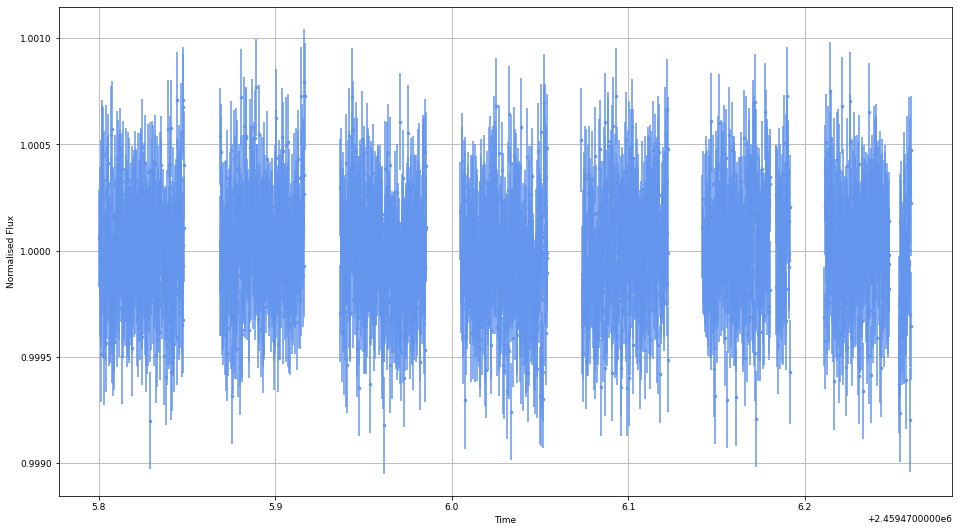

In [3]:
# Let's see the data
plt.figure(figsize=(16,9))
plt.errorbar(tim[instrument], fl[instrument], yerr=fle[instrument], fmt='.', c='cornflowerblue')
plt.xlabel('Time')
plt.ylabel('Normalised Flux')
plt.grid()

In [4]:
# Planetary parameters
P = 3.52474859                           # Stassun et al. 2017
BJD_0 = 2452826.629283                   # Bonomo et al. 2017
cycle = round((tim9[0]-BJD_0)/P)
T_0 = BJD_0 + (cycle)*P
T_ec = T_0 + (P/2)

# Other planetary parameters
rprs, rprs_err = 0.12175, 0.00011        # From Various literature
dep, dep_err = 14822.2681, 27.7803       # Calculated from Rp/R* (stored in ppm)
aR, aR_err = 8.8066, 0.0513              # From various literature
inc, inc_err = 86.7438, 0.0221           # From various literature
bb, bb_err = 0.5002, 0.0045              # Calculated from a/R* and inc; b = (a/R*)*cos(inclination)
t14, t14_err = 0.12840, 0.00096          # Calculated from P0, a/R*, inc, and Rp/R*; T14 = P0*(arcsin((Rstar/a)*(((1+k)**2-b**2)**.5/sin(i)))/pi)
D, Derr = dep/1e6, dep_err/1e6           # Depth stored in absolute units from ppm
W, Werr = t14/P, t14_err/P               # Width stored in phase (T14 days/P)

In [5]:
# Priors --- 
# Planetary parameters
params_P = ['P_p1', 't0_p1', 'p_p1_' + instrument, 'b_p1', 'ecc_p1', 'omega_p1', 'a_p1', 'fp_p1_' + instrument, 't_secondary_p1']
dist_P = ['fixed', 'fixed', 'normal', 'normal', 'fixed', 'fixed', 'normal', 'uniform', 'normal']
hyper_P = [P, T_0, [rprs, rprs_err], [bb, bb_err], 0., 90., [aR, aR_err], [1e-6,2e-4], [T_ec, 0.01]]

# Instrumental parameters
params_ins = ['mdilution_' + instrument, 'mflux_' + instrument, 'sigma_w_' + instrument]
dist_ins = ['fixed', 'normal', 'loguniform']
hyper_ins = [1., [0., 0.1], [0.1, 10000.]]

# GP parameters (SHO kernel)
par_gp = ['GP_S0_' + instrument, 'GP_omega0_' + instrument, 'GP_Q_' + instrument]
dist_gp = ['uniform', 'uniform', 'fixed']
hyper_gp = [[np.exp(-30.), np.exp(-5.)], [np.exp(-10.), np.exp(10.)], 1/np.sqrt(2)]

# Linear parameters
par_lin, dist_lin, hyper_lin = [], [], []
for i in range(lins1.shape[0]):
    par_lin.append('theta' + str(i) + '_' + instrument)
    dist_lin.append('uniform')
    hyper_lin.append([-1.,1.])

params = params_P + params_ins + par_lin + par_gp
dist = dist_P + dist_ins + dist_lin + dist_gp
hyper = hyper_P + hyper_ins + hyper_lin + hyper_gp

priors = juliet.utils.generate_priors(params, dist, hyper)


# And analysis
dataset = juliet.load(priors=priors, t_lc=tim, y_lc=fl, yerr_lc=fle, linear_regressors_lc=lin_pars, GP_regressors_lc=gp_pars, out_folder='Analysis/Analysis3')
results = dataset.fit(sampler = 'dynesty', nthreads = 8)

29614it [05:33, 88.70it/s, +500 | bound: 376 | nc: 1 | ncall: 916224 | eff(%):  3.289 | loglstar:   -inf < 17123.770 <    inf | logz: 17065.040 +/-  0.333 | dlogz:  0.001 >  0.509]


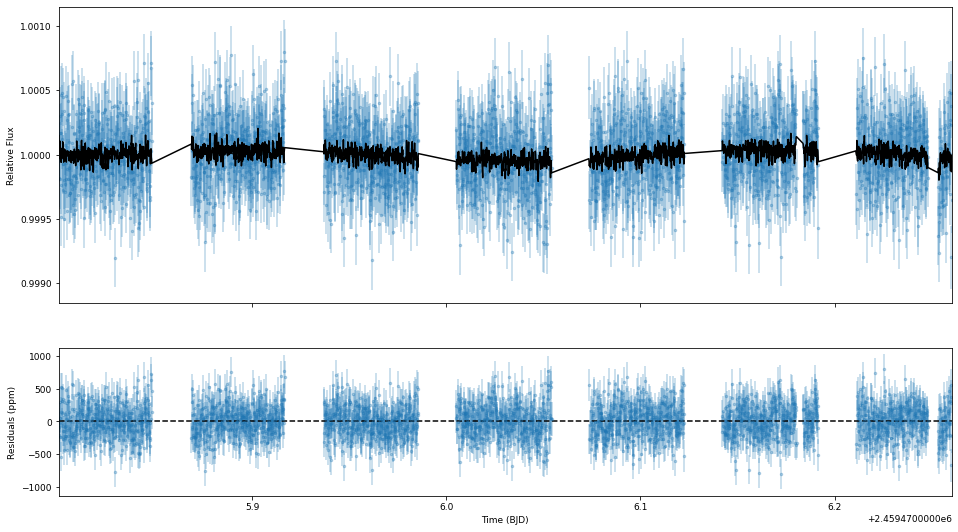

In [6]:
# Plot
model = results.lc.evaluate(instrument)

# Making a plot
fig = plt.figure(figsize=(16,9))
gs = gd.GridSpec(2,1, height_ratios=[2,1])

# Top panel
ax1 = plt.subplot(gs[0])
ax1.errorbar(tim[instrument], fl[instrument], yerr=fle[instrument], fmt='.', alpha=0.3)
ax1.plot(tim[instrument], model, c='k', zorder=100)
ax1.set_ylabel('Relative Flux')
ax1.set_xlim(np.min(tim[instrument]), np.max(tim[instrument]))
ax1.xaxis.set_major_formatter(plt.NullFormatter())

# Bottom panel
ax2 = plt.subplot(gs[1])
ax2.errorbar(tim[instrument], (fl[instrument]-model)*1e6, yerr=fle[instrument]*1e6, fmt='.', alpha=0.3)
ax2.axhline(y=0.0, c='black', ls='--')
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Time (BJD)')
ax2.set_xlim(np.min(tim[instrument]), np.max(tim[instrument]))

plt.show()

In [7]:
fp1 = results.posteriors['posterior_samples']['fp_p1_' + instrument] * 1e6
print('Eclipse depth: {:.4f} +/- {:.4f} ppm'.format(np.median(fp1), np.std(fp1)))

Eclipse depth: 35.5177 +/- 22.5678 ppm
